# APP中不同Banner位效果A/B组测试分析

## 项目背景介绍

Banner广告又叫横幅广告、通栏广告、广告条，常见于APP中的顶部或底部，我们又把banner称为资源位，是因为它除了要承担吸引用户眼球的责任外，还需要向用户传达信息，在传达信息的基础上，banner位的另一个作用就是促使用户产生行动，使他们在看过banner上呈现的信息后，产生想点进去参与的欲望。本项目通过设计合理的A/B组对比测试实验，并通过实验结果的可视化展示说明A/B组点击率的不同。

引入科学计算和绘图相关包

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from numpy import array
from pandas import Series, DataFrame
from impala.dbapi import connect
import matplotlib.pyplot as plt
import matplotlib
import netrc
import sys
import seaborn as sns
sns.set_style('whitegrid')
reload(sys)
sys.setdefaultencoding("utf-8")

## 如何保证A/B组用户数量均衡

* 方案一：将数据库中所有历史用户随机分为均衡的A/B两组，并在A/B组的Banner位中配置不同的活动素材
* 方案二：Nginx作为反向代理，负责将客户端的HTTP请求转发到对应的业务系统，它记录了访问客户端的IP，访问事件，请求方法，请求路径等信息，通过Nginx将当日来访的用户随机分为A/B两组，并在A/B组的Banner位中配置不同的活动素材

对比上述两种方案可以发现明显方案二分出的A/B组用户数据更加均衡，如果将所有历史用户随机分为均衡的两组，并不能保证在进行测试期间来访的A/B组用户数量均衡，方案二在Nginx端将当日来访的用户随机分为两组，能够保证测试期间A/B组用户数量均等且随机。

## 数据获取

下面导入A/B组原始数据

In [5]:
cur.execute(sql_1)
columns = [column[0] for column in cur.description]
df = pd.DataFrame(cur.fetchmany(1000))
frames = []
while not df.empty:
    frames.append(df)
    df = pd.DataFrame(cur.fetchmany(1000))
banner_df = pd.concat(frames)
banner_df.columns = columns

In [6]:
banner_df[['date_desc','citycode','user_type','banner_rn',
           'banner_id','banner_click', 'url_path']].head()

,date_desc,citycode,user_type,banner_rn,banner_id,banner_click,url_path
0,2017-04-28,59,B,2,284393,None,/aladdin/58fea57abbd49922d89b0721/393.shtml
1,2017-04-28,59,B,1,284389,None,/aladdin/5900798dbbd49922d89b0887/425.shtml
2,2017-04-28,265,B,5,271267,None,/aladdin/58e858f308780b3c9c2d44fa/297.shtml
3,2017-04-28,265,B,4,271253,None,/aladdin/590309f8bbd49922d89b094b/431.shtml
4,2017-04-28,265,B,3,271247,None,/aladdin/58f822b7bbd49922d89b064c/383.shtml


上面表格数据为从2017-04-28日至2017-05-02日的Banner位点击效果，date_desc表示用户浏览日期，citycode是APP首页用户所属城市，随机将用户分为A/B两组标记为user_type,banner_rn表示位于第几个Banner位，banner_click表示某个用户在该Banner位的点击次数，url_path为该Banner位素材.

## 数据清洗

为了方便数据可视化展示，将日期格式转换为月日的形式。

In [7]:
banner_df['date_desc'] = banner_df['date_desc'].apply(lambda x:pd.to_datetime(x).strftime('%m-%d'))

## 数据探查

In [8]:
banner_df.shape

(272630, 8)

可知上述时间段内参与测试的A/B组数据一共有272630条。

In [9]:
banner_df.describe()

,date_desc,user_id,citycode,user_type,banner_rn,banner_id,banner_click,url_path
count,272630,272630,272630,272630,272630,272630,16949,272630
unique,5,44799,352,2,6,360,32,11
top,04-28,116192641,22,A,1,288695,1,/aladdin/5900798dbbd49922d89b0887/425.shtml
freq,74142,210,19526,137053,73746,23641,10220,73746


通过上述方法可以看到测试期间共有44799名用户参与到A/B测试中，覆盖到了352个城市，参与测试的Banner位最大达到6个。

In [10]:
date_unique = banner_df.date_desc.unique()

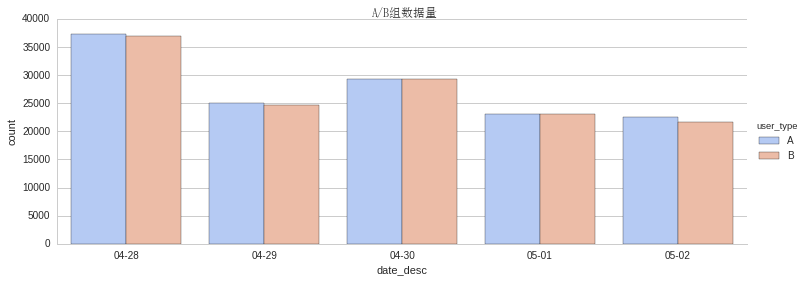

In [11]:
plot = sns.factorplot('date_desc', hue='user_type', kind='count', 
                      data=banner_df, palette='coolwarm', 
               x_order=date_unique, aspect=2.6, hue_order=['A','B'])
plot.fig.suptitle('A/B组数据量', fontproperties=myfont)

上图中Y轴表示原始数据量，由图可知A/B组数据量大体相当，原始数据中A/B组已经均等划分。

## 数据计算

In [12]:
banner_df.dropna(inplace=True)

In [13]:
banner_df['banner_click'] = pd.to_numeric(banner_df.banner_click)

In [14]:
banner_df['user_id'] = pd.to_numeric(banner_df.user_id)

按照日期、A/B组、Banner位顺序合并统计点击次数和点击用户数。

In [15]:
group2 = banner_df.groupby(['date_desc','user_type', 'banner_rn'])[['banner_click','user_id']]

In [16]:
gp2_df = group2.agg({"banner_click":np.sum, "user_id": lambda x:x.nunique()})

In [17]:
gp2_df.reset_index(inplace=True)

In [18]:
gp2_df.head(10)

,date_desc,user_type,banner_rn,banner_click,user_id
0,04-28,A,1,729,320
1,04-28,A,2,513,287
2,04-28,A,3,1257,716
3,04-28,A,4,1173,575
4,04-28,A,5,196,115
5,04-28,A,6,47,27
6,04-28,B,1,328,170
7,04-28,B,2,2238,1147
8,04-28,B,3,698,344
9,04-28,B,4,455,203


上表为按天统计A/B组用户不同banner位的总点击次数和点击用户数

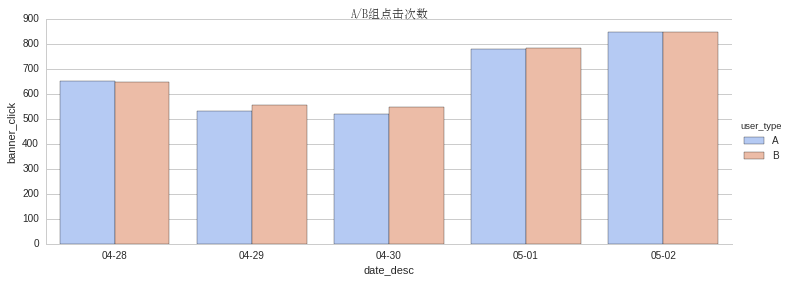

In [20]:
plot = sns.factorplot(x='date_desc', y='banner_click', hue='user_type', data=gp2_df, 
               palette='coolwarm', kind='bar', ci=False,
               x_order=date_unique, aspect=2.6)
plot.fig.suptitle('A/B组点击次数', fontproperties=myfont)
#plot.savefig("a_b_clicks.png", dpi=300)

上图为按照天统计A/B组用户点击次数的总和，由图可知A/B组用户banner位的总点击次数并没有明显的差异。

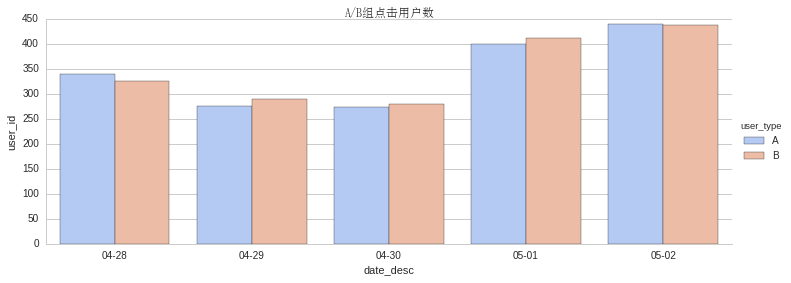

In [22]:
plot = sns.factorplot(x='date_desc', y='user_id', hue='user_type', data=gp2_df, 
               palette='coolwarm', kind='bar', ci=False,
               x_order=date_unique, aspect=2.6)
plot.fig.suptitle('A/B组点击用户数', fontproperties=myfont)
#plot.savefig("a_b_users.png", dpi=300)

上图为按照天统计A/B组用户数量的总和，由图可知A/B组用户数量并没有明显的差异。

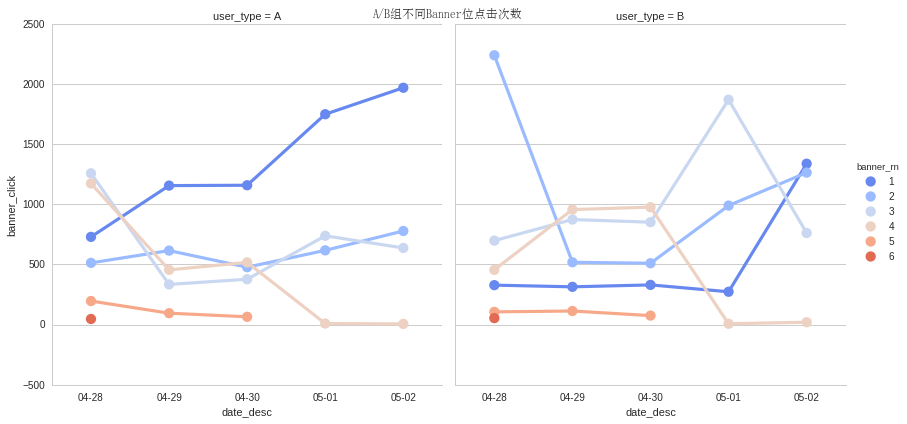

In [23]:
plot = sns.factorplot(x='date_desc', y='banner_click', col='user_type',hue='banner_rn', data=gp2_df, 
               palette='coolwarm', size=6, x_order=date_unique)
plot.fig.suptitle('A/B组不同Banner位点击次数', fontproperties=myfont)

   上图中Y轴表示Banner位的点击次数，1-6号为不同Banner位的点击次数，左图表示A组用户不同Banner位的点击次数，右图表示B组用户不同Banner位的点击次数。单看A组用户中，1号Banner位的点击次数比其他Banner位的点击次数高，仅仅看B组用户中，点击次数最高的Banner位并不是第1号，偶尔是第2号Banner点击次数最高，有时是第3号Banner点击次数最高

** 在A/B组中上述的曝光规则均相同，A组中的点击次数与Banner位之间的关系相关性更强，比B组有序 **

** A组的1、2号Banner位的合并点击次数比B组1、2号Banner位高 **

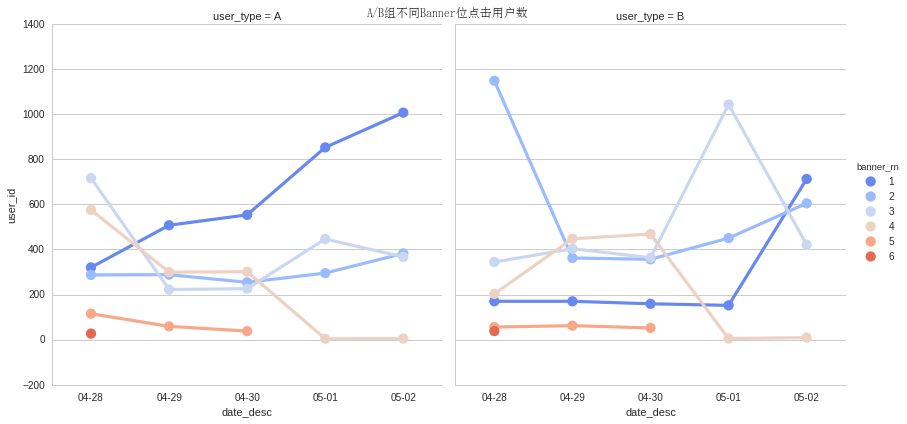

In [24]:
plot = sns.factorplot(x='date_desc', y='user_id', col='user_type', hue='banner_rn', data=gp2_df, 
               palette='coolwarm', size=6, x_order=date_unique)
plot.fig.suptitle('A/B组不同Banner位点击用户数', fontproperties=myfont)

上图中Y轴表示Banner位的点击用户数量，趋势和结论与点击次数相似。

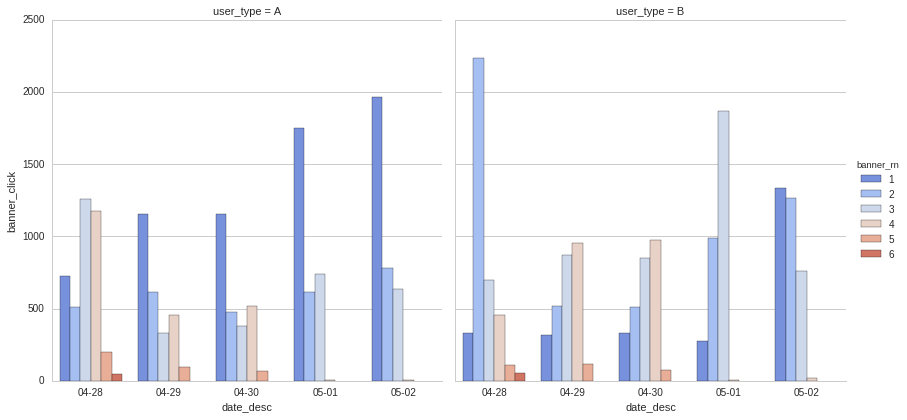

In [25]:
sns.factorplot(x='date_desc', y='banner_click', col='user_type', data=gp2_df, size=6,
               palette='coolwarm', x_order=date_unique, hue='banner_rn', kind='bar', aspect=1)

上图中Y轴依然为相应Banner位的点击次数，左右图分别为A/B组用户中不同Banner位点击次数的柱状图展示，左侧说明A组中点击次数最高的依然为第1位Banner，反之右图不同Banner位间的点击次数无序。上图是为了尝试使用不同的数据可视化方法说明问题，看哪一种可视化方法更加直观。

**下面按照不同城市筛选出点击次数最高的5个城市，继续进行分析，看看不同城市间的Banner位点击次数是否不同**

In [26]:
citycode_top = banner_df.groupby('citycode')[['banner_click']].sum()
citycode_top.reset_index(inplace=True)

In [27]:
city_top5 = citycode_top.sort('banner_click', ascending=False)[['citycode']].head()

In [28]:
banner_clean = pd.merge(banner_df, city_top5)

In [29]:
banner_clean[['date_desc','citycode','user_type','banner_rn',
              'banner_id','banner_click','url_path']].head()

,date_desc,citycode,user_type,banner_rn,banner_id,banner_click,url_path
0,04-28,377,A,3,286271,1,/aladdin/58fea57abbd49922d89b0721/393.shtml
1,04-28,377,A,4,285199,2,/aladdin/58fea57abbd49922d89b0721/393.shtml
2,04-28,377,A,2,284127,1,/aladdin/58fea57abbd49922d89b0721/393.shtml
3,04-28,377,A,3,288703,2,/aladdin/58f822b7bbd49922d89b064c/383.shtml
4,04-28,377,A,2,288695,3,/aladdin/5900798dbbd49922d89b0887/425.shtml


In [30]:
group1 = banner_clean.groupby(['date_desc', 'user_type', 'citycode','banner_rn'])[['banner_click', 'user_id']]

In [31]:
gp1_df = group1.agg({'banner_click':np.sum, 'user_id':lambda x: x.nunique()})
gp1_df.reset_index(inplace=True)

In [32]:
gp1_df['banner_rn'] = pd.to_numeric(gp1_df['banner_rn'])

In [33]:
gp1_df.head()

,date_desc,user_type,citycode,banner_rn,banner_click,user_id
0,04-28,A,22,1,113,35
1,04-28,A,22,2,72,39
2,04-28,A,22,3,118,65
3,04-28,A,22,4,193,72
4,04-28,A,22,5,42,15


上表是citycode为22的A城市各个Banner位统计结果

In [34]:
gp1_df['citycode'] = pd.to_numeric(gp1_df['citycode'])

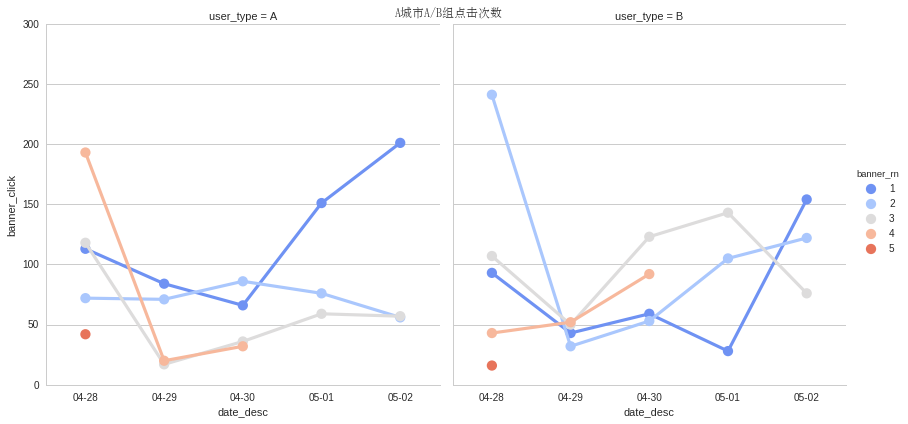

In [35]:
plot = sns.factorplot(x='date_desc', y='banner_click', col='user_type',hue='banner_rn', 
               data=gp1_df[gp1_df.citycode==22], size=6,
               palette='coolwarm', x_order=date_unique)
plot.fig.suptitle('A城市A/B组点击次数', fontproperties=myfont)

由上图可见A城市的点击次数趋势与总点击趋势相同，但A组中4月30日2号Banner位比1号Banner位点击次数高。

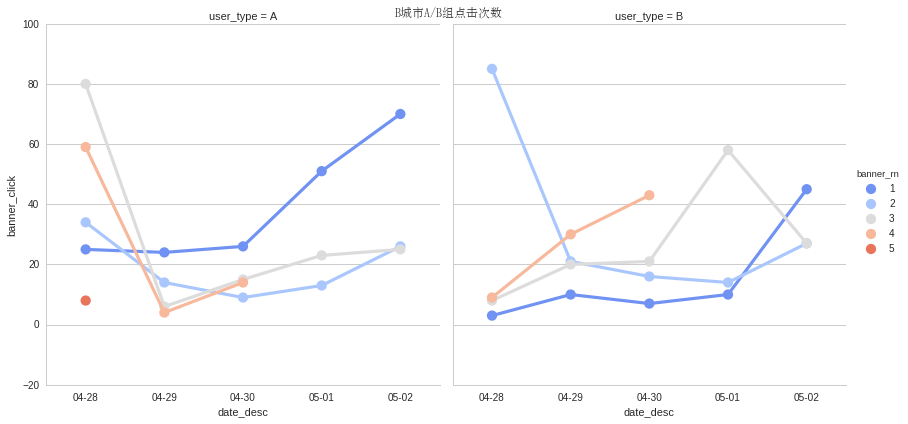

In [36]:
plot = sns.factorplot(x='date_desc', y='banner_click', col='user_type',hue='banner_rn', 
               data=gp1_df[gp1_df.citycode==377], size=6,
               palette='coolwarm', x_order=date_unique)
plot.fig.suptitle('B城市A/B组点击次数', fontproperties=myfont)

由上图可见B城市的点击次数趋势与总点击趋势相同。

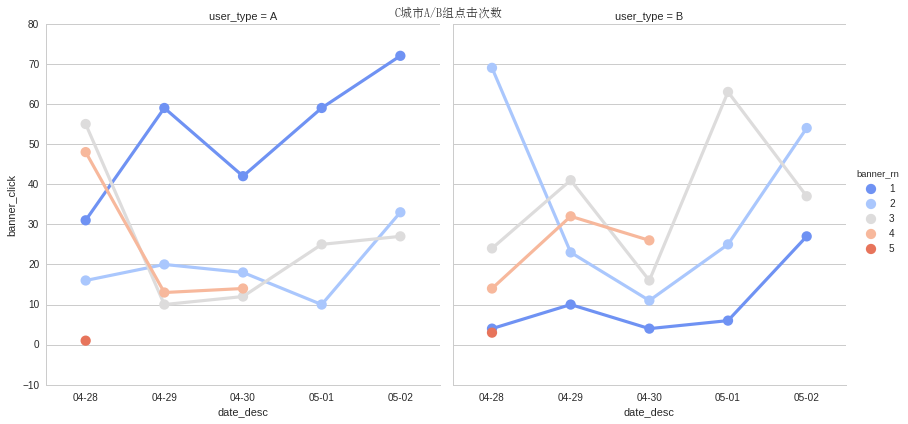

In [37]:
plot = sns.factorplot(x='date_desc', y='banner_click', col='user_type',hue='banner_rn', 
               data=gp1_df[gp1_df.citycode==416], size=6,
               palette='coolwarm', x_order=date_unique)
plot.fig.suptitle('C城市A/B组点击次数', fontproperties=myfont)

由上图可见C城市的点击次数趋势与总点击趋势相同。

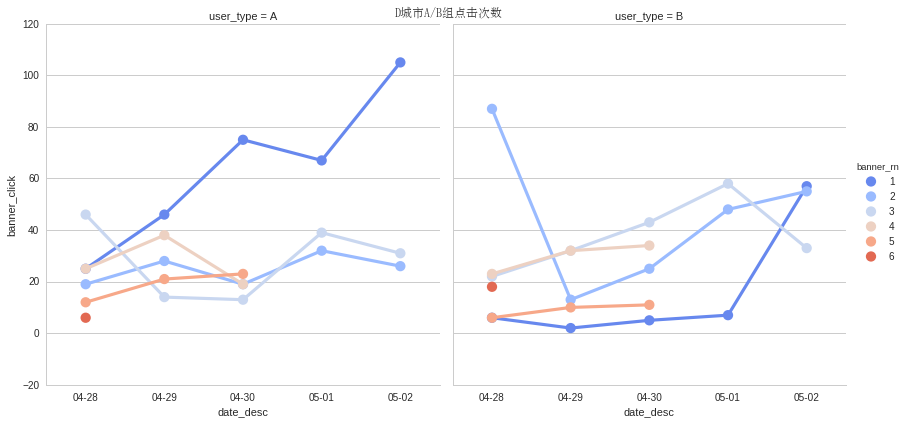

In [38]:
plot = sns.factorplot(x='date_desc', y='banner_click', col='user_type',hue='banner_rn', 
               data=gp1_df[gp1_df.citycode==69], size=6,
               palette='coolwarm', x_order=date_unique)
plot.fig.suptitle('D城市A/B组点击次数', fontproperties=myfont)

由上图可见D城市的点击次数趋势与总点击趋势相同。

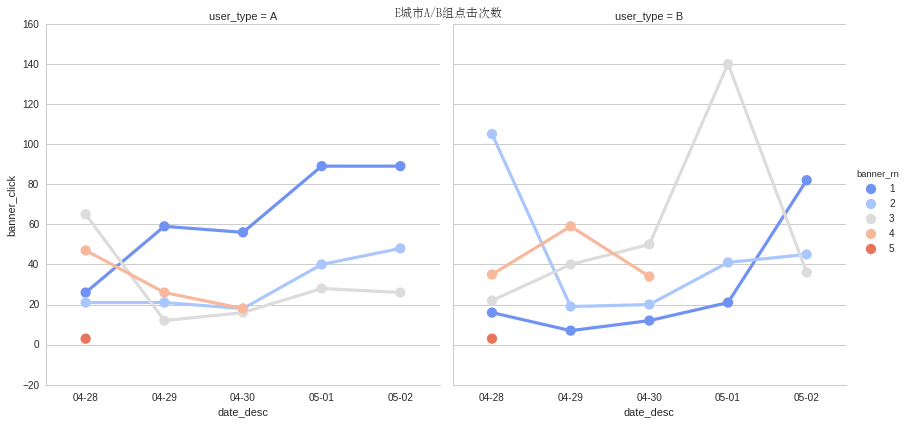

In [39]:
plot = sns.factorplot(x='date_desc', y='banner_click', col='user_type',hue='banner_rn', 
               data=gp1_df[gp1_df.citycode==72], size=6,
               palette='coolwarm', x_order=date_unique)
plot.fig.suptitle('E城市A/B组点击次数', fontproperties=myfont)

由上图可见E城市的点击次数趋势与总点击趋势相同。

由上述5个点击次数排名最高的5个城市可以看出，A/B组中总体趋势与不同城市间的趋势大致相同。

下面回到所有城市的数据中，按照Banner位一一比对A/B组不同的点击次数。

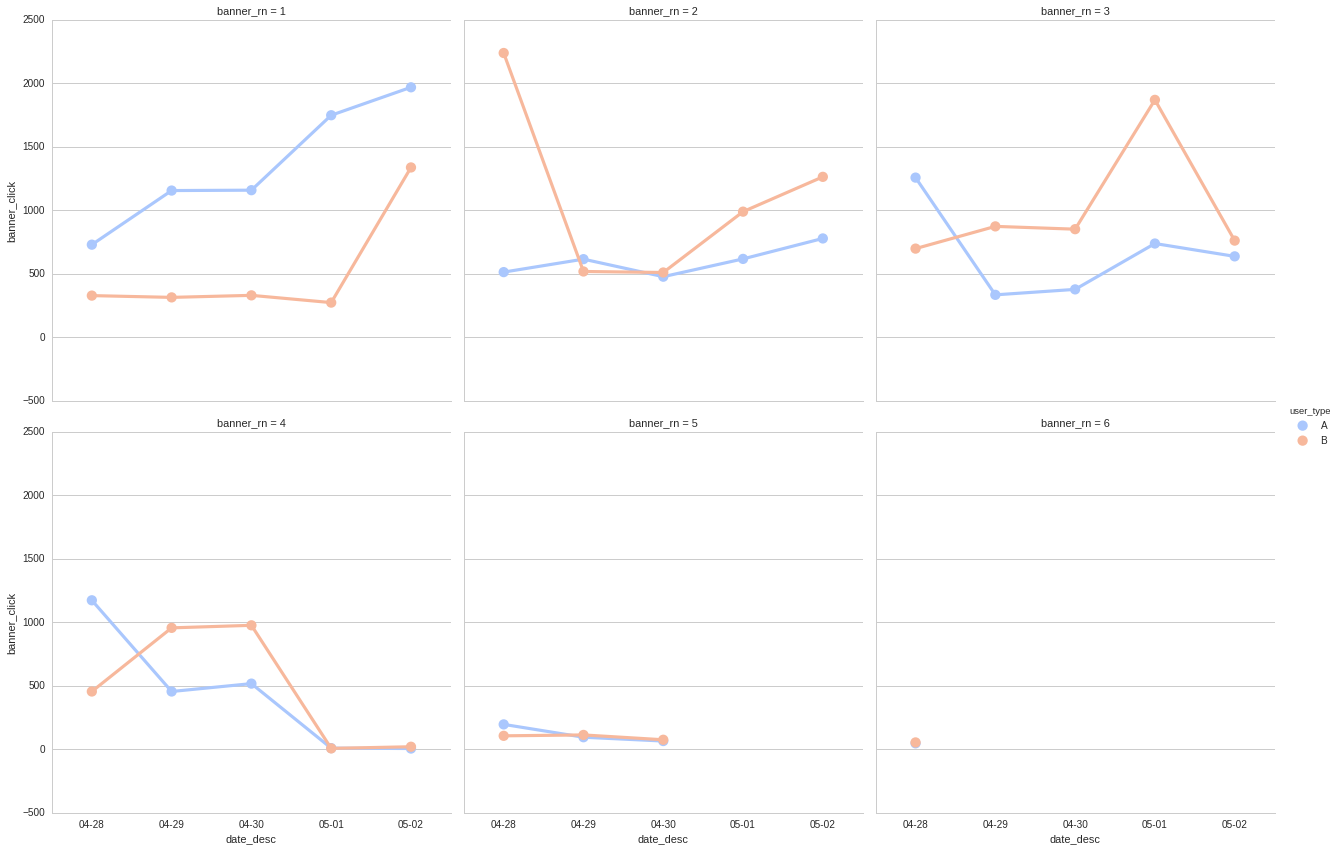

In [40]:
plot = sns.factorplot(x='date_desc', y='banner_click', col='banner_rn',hue='user_type', 
               data=gp2_df, palette='coolwarm', col_wrap=3, size=6, x_order=date_unique )


上图中所有Y轴均表示Banner位的点击次数，图中橙色代表B组用户，蓝色代表A组用户，上左图中banner_rn=1表示1号Banner位A/B组的不同点击次数，上中图中banner_rn=2表示2号Banner位A/B组的不同点击次数，依次展示到6号Banner位。

上图说明1号Banner中A组的点击次数明显高于B组，其余Banner位基本都是B组的点击次数高。

In [41]:
gp2_df['banner_rn'] = pd.to_numeric(gp2_df['banner_rn'])

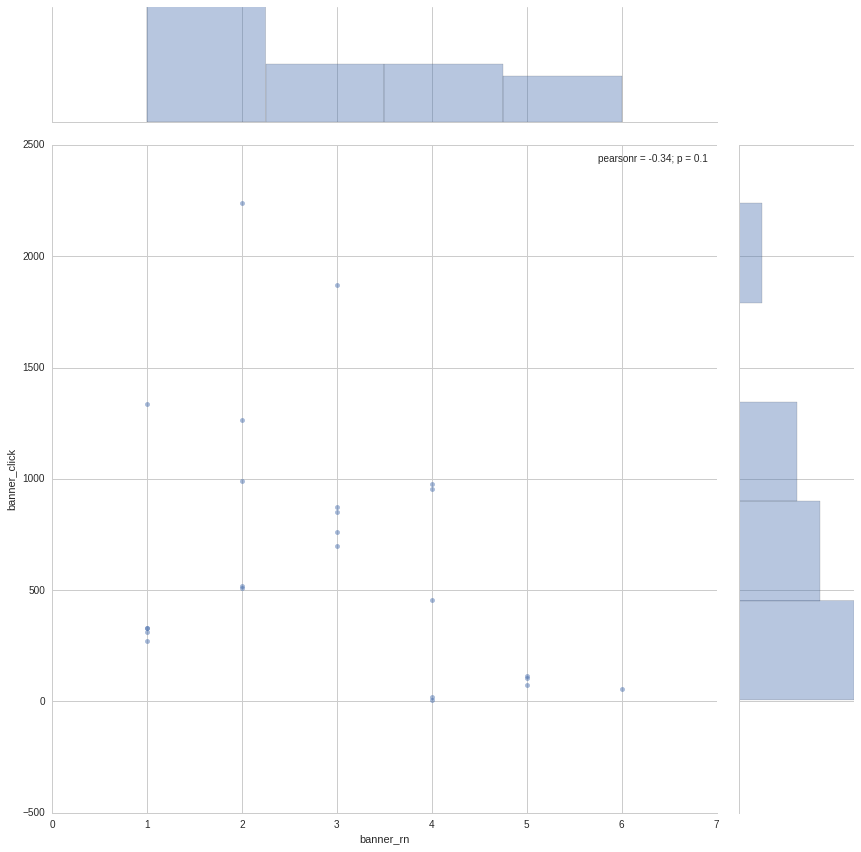

In [42]:
sns.jointplot('banner_rn', 'banner_click', data=gp2_df[gp2_df.user_type=='B'], 
              kind='scatter', size=12, alpha=0.5)

B组数据：上图横轴分别为1-6号Banner位，纵轴为Banner位的点击次数，pearsonr系数为0.34，说明相关关系较弱。

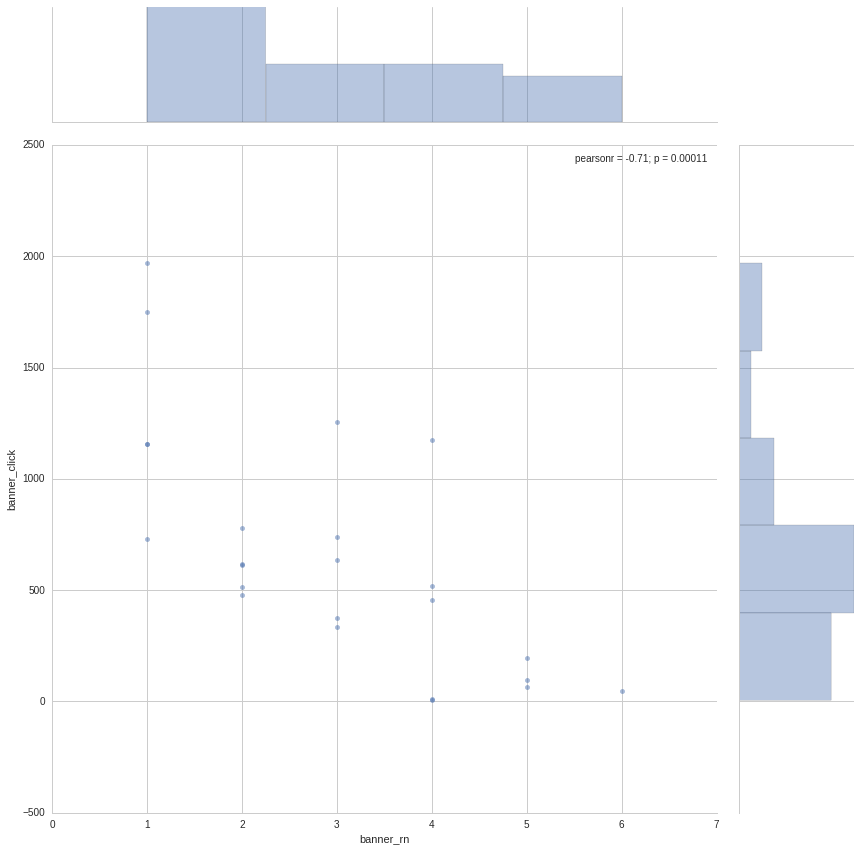

In [43]:
sns.jointplot('banner_rn', 'banner_click', data=gp2_df[gp2_df.user_type=='A'], 
              kind='scatter', alpha=0.5, size=12)

A组数据：上图横轴分别为1-6号Banner位，纵轴为Banner位的点击次数，pearsonr系数为0.71，与B组相比，A组中Banner位顺序与点击次数的相关性更高。

In [44]:
banner_rn1_2 = gp2_df[gp2_df.banner_rn.isin([1,2])]

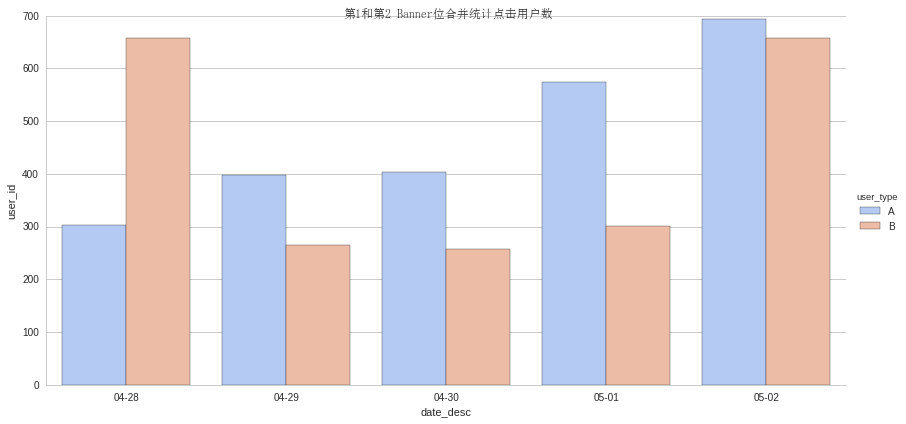

In [46]:
plot = sns.factorplot(x='date_desc', y='user_id', hue='user_type', data=banner_rn1_2, 
               palette='coolwarm', kind='bar', ci=False, size=6,
               x_order=date_unique, aspect=2)
plot.fig.suptitle('第1和第2 Banner位合并统计点击用户数', fontproperties=myfont)

上图仅仅统计1、2号Banner的A/B组点击用户数，由图可见从4月29日开始，A组的点击次数比B组高，A组用户的1、2号Banner位点击用户数量比B组高。

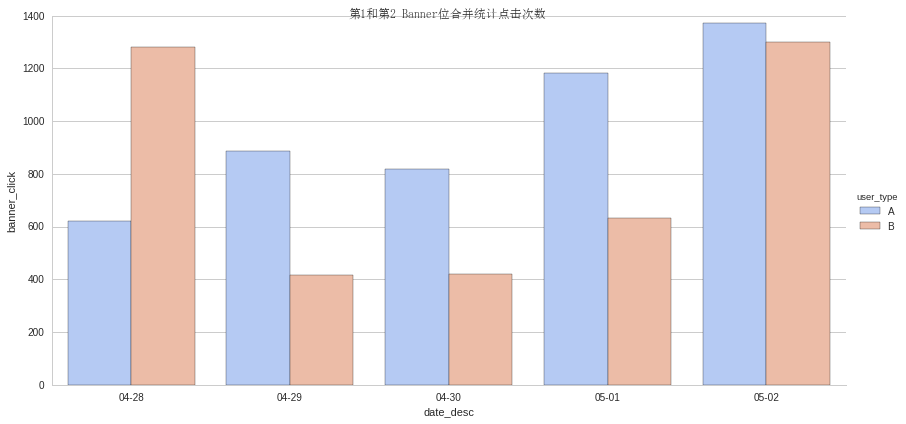

In [48]:
plot = sns.factorplot(x='date_desc', y='banner_click', hue='user_type', data=banner_rn1_2, 
               palette='coolwarm', kind='bar', ci=False, size=6,
               x_order=date_unique, aspect=2)
plot.fig.suptitle('第1和第2 Banner位合并统计点击次数', fontproperties=myfont)

上图仅仅统计1、2号Banner的A/B组点击次数，由图可见从4月29日开始，A组的点击次数比B组高。

In [50]:
cur.execute(sql_2)
columns = [column[0] for column in cur.description]
df = pd.DataFrame(cur.fetchmany(1000))
frames = []
while not df.empty:
    frames.append(df)
    df = pd.DataFrame(cur.fetchmany(1000))
cost_df = pd.concat(frames)
cost_df.columns = columns

In [51]:
cost_df['date_desc'] = cost_df['date_desc'].apply(lambda x : pd.to_datetime(x).strftime('%m-%d'))

In [52]:
cost_df.dropna(inplace=True)

In [53]:
cost_df.shape

(497, 4)

下面约定当天浏览并且当天购买的用户认定为该组的购买用户，分别统计购买金额和购买人数如下。

In [54]:
cost_gp1 = cost_df.groupby(['date_desc', 'user_type'])[['user_id', 'cost']]

In [55]:
cost_df = cost_gp1.agg({'user_id':lambda x: x.nunique(), 'cost':np.sum})

In [56]:
cost_df.reset_index(inplace=True)

In [57]:
cost_df.head()

,date_desc,user_type,cost,user_id
0,04-28,A,15185.76,54
1,04-28,B,15332.92,54
2,04-29,A,3906.92,27
3,04-29,B,5272.62,25
4,04-30,A,10157.01,35


上表为A/B组从4月28日开始的购买金额合计（cost）和购买用户数（user_id）

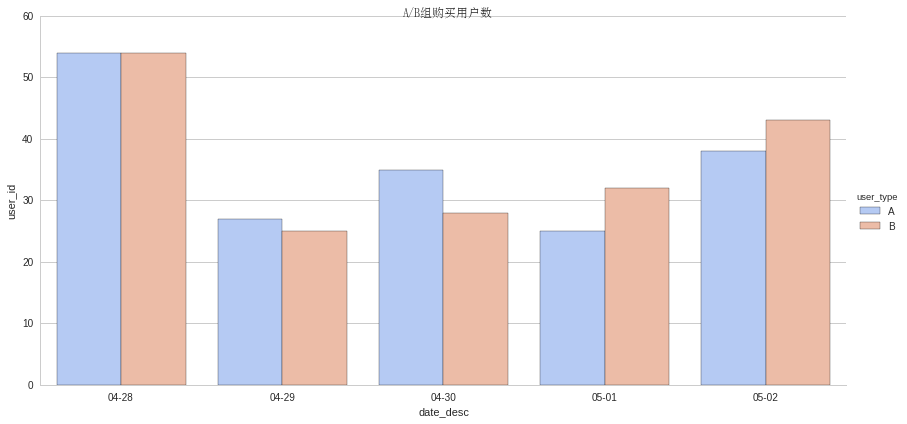

In [58]:
plot = sns.factorplot(x='date_desc', y='user_id', hue='user_type', data=cost_df, 
               palette='coolwarm', kind='bar', size=6,
               x_order=date_unique, aspect=2)
plot.fig.suptitle('A/B组购买用户数', fontproperties=myfont)

上图中Y轴为购买用户数，可见4月28日A/B购买用户数量相同，29、30日A组用户购买数量略高，5月1、2日B组购买用户数量略高，A/B组间的购买用户数并没有明显的规律。

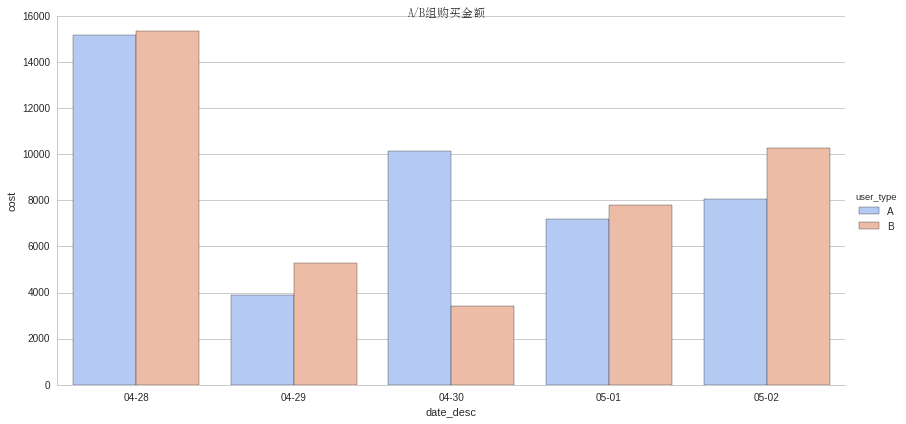

In [59]:
plot = sns.factorplot(x='date_desc', y='cost', hue='user_type', data=cost_df, 
               palette='coolwarm', kind='bar', size=6,
               x_order=date_unique, aspect=2)
plot.fig.suptitle('A/B组购买金额', fontproperties=myfont)

上图中Y轴为购买金额总和，A/B组间暂时没有明显规律。

## 项目结论

* 1.测试期间，A组用户1、2号Banner位的点击次数明显比B组用户高
* 2.A/B组中Banner位的点击率提升与该组用户的购买金额并没有直接的关系，用户是否购买不仅仅与Banner位有关
* 3.通过系统化的实现方式，大规模的筛选素材并提高Banner位素材与各个用户间的相关关系能够提升资源位的使用效率，显著提高用户的点击率